# **Sensix - Aprendizado Supervisionado - Segmentação Semântica**

Importando as Bibliotecas Necessárias





In [ ]:
!pip3 install keras==2.4.3

In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
import segmentation_models as sm
from segmentation_models.utils import set_trainable
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
#from model import *
#from data import *
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, CSVLogger

Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extraindo e colocando o dataset na pasta /tmp

In [ ]:
!cp /content/drive/MyDrive/jupiter/Datasets/Supervisionated/yiq_dataset.zip /tmp

In [ ]:
!cp /content/drive/MyDrive/jupiter/Redes\ Neurais/vgg16_linknet_dataset_weedraw.hdf5 /tmp

In [ ]:
import os
import zipfile

local_zip = '/tmp/yiq_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [ ]:
!rm -r /tmp/mask_train/ /tmp/mask_validation/ /tmp/train /tmp/validation/

rm: cannot remove '/tmp/mask_train/': No such file or directory
rm: cannot remove '/tmp/mask_validation/': No such file or directory
rm: cannot remove '/tmp/train': No such file or directory
rm: cannot remove '/tmp/validation/': No such file or directory


In [ ]:
def prepare_dataset_func_1(img):
    '''
    img: array que representa a imagem que será modificada:
    
    description: Representa efeitos relacionados a coloração da imagem. Nenhuma
    rotação ou aproximação (zoom) é dado. Apenas possui filtros que alteram as 
    caracteristicas gerais das imagens
    
    return: array
    O array retornado representa a imagem modificada
    '''
    img = img.astype('uint8')
    if random_func(percentage = 10):
        seq = iaa.Sequential([
            iaa.Affine(rotate=(0, 90)),
            #iaa.Crop(percent=(0.1, 0.2)),
            iaa.LinearContrast((1.0, 1.9)),
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            iaa.AdditiveGaussianNoise(scale=(10, 20)),
            iaa.Crop(percent=(0, 0.2)),
            iaa.AddToBrightness((-30, 30)),
            iaa.AddToHue((-50, 50)),
            #iaa.flip.Fliplr(0.5)
            iaa.AllChannelsHistogramEqualization()
        ],
        random_order=True) # Ordem aleatoria
        images_aug = seq(image=img)
    else:
        images_aug = img
    
    images_aug = np.expand_dims(images_aug, axis=0)
    images_aug = images_aug.astype('float32')
    return (images_aug)

In [ ]:
def adjust_data(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask >= 0.5] = 1
        mask[mask < 0.5] = 0
    return (img,mask)

In [ ]:
def train_generator(batch_size, 
                   train_path,
                   image_folder,
                   mask_folder,
                   #aug_dict,
                   preprocessing_function,
                   image_color_mode = "grayscale",
                   mask_color_mode = "grayscale", 
                   image_save_prefix  = "image", 
                   mask_save_prefix  = "mask",
                   flag_multi_class = False,
                   num_class = 1,
                   save_to_dir = None,
                   target_size = (256,256),
                   seed = 1):
    '''
    Can generate image and mask at the same time. Use the same seed for image_datagen and mask_datagen to ensure 
    the transformation for image and mask is the same. If you want to visualize the results of generator, set 
    save_to_dir = "your path"
    '''
    
    image_datagen = ImageDataGenerator(preprocessing_function)
    #mask_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(preprocessing_function)
    
    image_generator = image_datagen.flow_from_directory(train_path,
                                                        classes = [image_folder],
                                                        class_mode = None,
                                                        color_mode = image_color_mode,
                                                        target_size = target_size,
                                                        batch_size = batch_size,
                                                        save_to_dir = save_to_dir,
                                                        save_prefix  = image_save_prefix,
                                                        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(train_path,
                                                        classes = [mask_folder],
                                                        class_mode = None,
                                                        color_mode = mask_color_mode,
                                                        target_size = target_size,
                                                        batch_size = batch_size,
                                                        save_to_dir = None,
                                                        save_prefix  = mask_save_prefix,
                                                        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator:
        img,mask = adjust_data(img, mask, flag_multi_class, num_class)
        yield (img,mask)

In [ ]:
def test_generator(batch_size,
                  test_path,
                  image_folder,
                  mask_folder,
                  image_color_mode = "grayscale",
                  mask_color_mode = "grayscale",
                  image_save_prefix  = "image",
                  mask_save_prefix  = "mask",
                  flag_multi_class = False,
                  num_class = 1, 
                  save_to_dir = None,
                  target_size = (256,256), seed = 2):
    '''
    Can generate image and mask at the same time. Use the same seed for image_datagen and mask_datagen to ensure 
    the transformation for image and mask is the same. If you want to visualize the results of generator, set 
    save_to_dir = "your path"
    '''
    
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(test_path,
                                                        classes = [image_folder],
                                                        class_mode = None,
                                                        color_mode = image_color_mode,
                                                        target_size = target_size,
                                                        batch_size = batch_size,
                                                        save_to_dir = save_to_dir,
                                                        save_prefix  = image_save_prefix,
                                                        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(test_path,
                                                      classes = [mask_folder],
                                                      class_mode = None,
                                                      color_mode = mask_color_mode,
                                                      target_size = target_size,
                                                      batch_size = batch_size,
                                                      save_to_dir = save_to_dir,
                                                      save_prefix  = mask_save_prefix,
                                                      seed = seed)
    
    test_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in test_generator:
        img,mask = adjust_data(img,mask,flag_multi_class,num_class)
        yield (img,mask)

Definindo como o Modelo fará o Data Augmentation

In [ ]:
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.07,
                    height_shift_range=0.07,
                    shear_range=0.07,
                    zoom_range=0.07,
                    horizontal_flip=True,
                    fill_mode='nearest')

Definindo o caminho das pastas de validação e treino. Inicializando o dimensionamento das imagens que serão lidas

In [ ]:
path_dataset = '/tmp/yiq_dataset/'
train_data_path = '/tmp/yiq_dataset/train'
validation_data_path = '/tmp/yiq_dataset/validation/' 

num_of_train_samples = sum(len(files) for _, _, files in os.walk(train_data_path))
num_of_validation_samples  = sum(len(files) for _, _, files in os.walk(validation_data_path))
print("Train Images : ", num_of_train_samples)
print("Validation Images  : ", num_of_validation_samples)

batch_size = 16
train_samples = num_of_train_samples
test_samples = num_of_validation_samples
steps_p_epoch = int(train_samples / batch_size)
val_steps = int(test_samples / batch_size)
nr_epochs = 400

Train Images :  713
Validation Images  :  237


# Colocando a rede para treinar

In [ ]:
folds = 1
from keras.preprocessing.image import ImageDataGenerator

for nr_fold in range(0, folds):
    BACKBONE = 'vgg16'
    preprocess_input = sm.get_preprocessing(BACKBONE)

    trainGene = train_generator(batch_size, 
                              path_dataset, 
                              'train',
                              'mask_train',
                              preprocessing_function=prepare_dataset_func_1,
                              save_to_dir = None, 
                              image_color_mode = "rgb"
                             )

    testGene = test_generator(batch_size, 
                              path_dataset,
                              'validation', 
                              'mask_validation', 
                              save_to_dir = None,
                              image_color_mode = "rgb")
    
    # define model
    DECODER = 'Linknet'
    #DECODER = 'Unet'
    #model = sm.Unet(backbone_name=BACKBONE,  encoder_weights='imagenet', encoder_freeze=True, classes=1, activation='sigmoid')
    model = sm.Linknet(backbone_name=BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=1, activation='sigmoid')
    #model = sm.Linknet(backbone_name=BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=1, activation='sigmoid', weights = '/tmp/vgg16_linknet_dataset_weedraw.hdf5')        
    opt = Adam(learning_rate=1e-3)

    model.compile(opt,
                  loss=sm.losses.jaccard_loss,
                  metrics=[sm.metrics.IOUScore(threshold=0.5),
                  sm.metrics.FScore(threshold=0.5), 
                  sm.metrics.precision])

    csv_logger = CSVLogger(BACKBONE + "_" + DECODER + ".csv", append=True)
    
    model_checkpoint = ModelCheckpoint(BACKBONE + "_" + DECODER + "_" + str(nr_fold) + ".hdf5", 
                                       monitor='loss',
                                       verbose=1,
                                       save_best_only=True)
    
    history = model.fit(trainGene, 
                        validation_data = testGene,
                        validation_steps = val_steps,
                        steps_per_epoch = steps_p_epoch,
                        epochs=nr_epochs,
                        callbacks=[model_checkpoint, csv_logger])

58892288/58889256 [==============================] - 1s 0us/step
Found 713 images belonging to 1 classes.
Found 713 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/400
44/44 [==============================] - ETA: 0s - loss: 0.5955 - iou_score: 0.5422 - f1-score: 0.6938 - precision: 0.4336Found 237 images belonging to 1 classes.
Found 237 images belonging to 1 classes.
44/44 [==============================] - 31s 266ms/step - loss: 0.5955 - iou_score: 0.5422 - f1-score: 0.6938 - precision: 0.4336 - val_loss: 0.7564 - val_iou_score: 0.2414 - val_f1-score: 0.3876 - val_precision: 0.2446

Epoch 00001: loss improved from inf to 0.59547, saving model to vgg16_Linknet_0.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/400
44/44 [==============================] - 16s 276ms/step - loss: 0.3498 - iou_score: 0.7287 - f1-score: 0.8423 - precision: 0.7115 - val_loss: 0.4465 - val_iou_score: 0.6097 - val_f1-score: 0.7566 - val_precision: 0.6416

Epoch 00002: loss improved from 0.59547 to 0.34977, saving model to vgg16_Linknet_0.hdf5
Epoch 3/400
44/44 [==============================] - 11s 256ms/step - loss: 0.2758 - iou_score: 0.7520 - f1-score: 0.8581 - precision: 0.8053 - val_loss: 0.4855 - val_iou_score: 0.5371 - val_f1-score: 0.6980 - val_precision: 0.8467

Epoch 00003: loss improved from 0.34977 to 0.27578, saving model to vgg16_Linknet_0.hdf5
Epoch 4/400
44/44 [==============================] - 11s 261ms/step - loss: 0.2583 - iou_score: 0.7570 - f1-score: 0.8614 - precision: 0.8350 - val_loss: 0.3225 - val_iou_score: 0.6987 - val_f1-score: 0.8221 - val_precision: 0.8319

Epoch 00004: loss improved from 0.27578 to 0.25833, saving model to vgg16_Linknet_0.hdf5
Epoch 5/400
44/44 [===============

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator?

dict_keys(['loss', 'iou_score', 'f1-score', 'precision', 'val_loss', 'val_iou_score', 'val_f1-score', 'val_precision'])


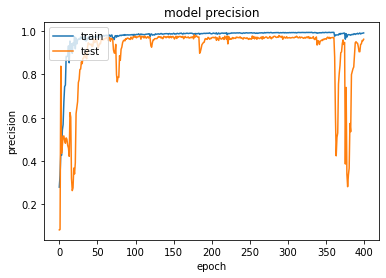

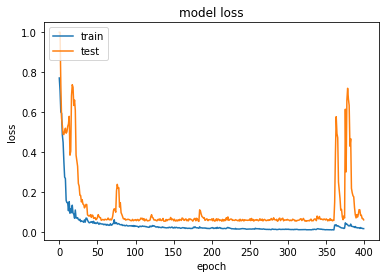

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!rm -r /tmp/dataset_sup

In [ ]:
print(model.summary)